# Using data from EBRAINS Knowledge Graph

**EBRAINS & IBRO Second Virtual Master Class on Brain Atlasing and Simulation Services, September 3, 2021**

Here we look at a short example how to get data from EBRAINS Knowledge Graph and incorporate them in a TVB simulation.

The following builds on the last Showcase 1 demo, see respective collab for more info: https://wiki.ebrains.eu/bin/view/Collabs/sga3-d1-1-showcase-1/

If `nilearn` is not available, fix that with:
```
!pip install nilearn
```

In [1]:
import ipywidgets as widgets
from os import path, environ
from nilearn import plotting,image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3frtu18j because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/opt/app-root/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# Setup siibra

### Setup local data cache

Siibra maintains a local cache of retrieved data. It will automatically choose the system default of your user account on most common operating systems, but in this online notebook we create an choose an explicit folder instead by setting the environment variable `SIIBRA_CACHEDIR`.

In [2]:
!mkdir -p /tmp/siibra
environ['SIIBRA_CACHEDIR'] = "/tmp/siibra"

If `siibra` is not available, fix that with:
```
!pip install siibra
```

In [3]:
import siibra as sb

[siibra:INFO]  Version: 0.1a8
[siibra:WARNING]  This is a development release. Use at your own risk. Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.
[siibra:INFO]  Loading cached configuration 'siibra-0.1a8' for spaces
[siibra:INFO]  Loading cached configuration 'siibra-0.1a8' for parcellations
[siibra:INFO]  Loading cached configuration 'siibra-0.1a8' for atlases


### Set a EBRAINS Knowledge Graph access token

Brainscapes retrieves some data from the EBRAINS Knowledge Graph, which requires
authentication. To do so, please follow these steps:

 1. If you do not yet have an EBRAINS account, register [here](https://ebrains.eu/register). As you are reading this notebook in the EBRAINS collaboratory, this is most probably not necessary at this point.
 2. Your EBRAINS account needs to be enabled for programmatic access to the EBRAINS Knowledge Graph to fetch metadata. This is formal step to acknowledge additional terms of use, and done quickly by emailing to the KG team. A link and template email to do so can be found right on top of the [Knowledge Graph developer page](https://kg.humanbrainproject.eu/develop.html).
 3. Create an authentication token for EBRAINS by visiting
[the EBRAINS authorization endpoint](https://nexus-iam.humanbrainproject.org/v0/oauth2/authorize). 
 4. Copy the token, and store it in the enviroment variable `HBP_AUTH_TOKEN` (just modify and execute the cell below accordingly).

Note that as of now, you have to get a new token (steps 3. and 4.) approximately every day.

In [4]:
w = widgets.Password(
    value='hbp auth token',
    disabled=False,
)
widgets.HBox([widgets.Label(value="Enter your token here: "), w])

In [5]:
sb.set_ebrains_token(w.value)

[siibra:INFO]  Updating EBRAINS authentication token.


# Getting the data

We first load the human atlas with the default parcellation.

In [6]:
atlas = sb.atlases["human"]
atlas.select_parcellation('julich')

[siibra:INFO]  Select "Julich-Brain Cytoarchitectonic Maps 2.9"


Julich-Brain Cytoarchitectonic Maps 2.9

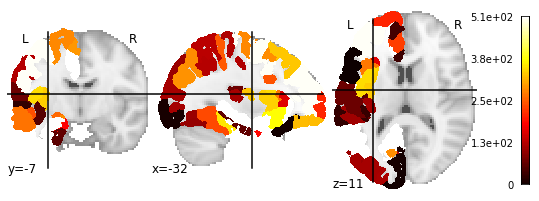

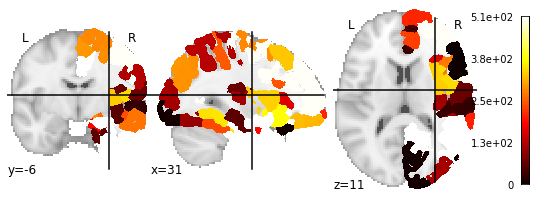

In [7]:
icbm_map = atlas.get_map(space="mni152")
for m in icbm_map.fetchall():
    plotting.plot_stat_map(m)

### Extract transmitter receptor densities

Transmitter receptor density fingerprints are linked to brain regions by their name in the EBRAINS Knowledge Graph. Like any data feature, they are accessed using the `get_features` method of the atlas, which makes use of the current selection in the atlas. The `get_features` method knows from the specified data modality that the match is determined from the brain region identified. 

In [8]:
atlas.clear_selection()
receptors = atlas.get_features(
    sb.modalities.ReceptorDistribution)

No cached data - querying the EBRAINS Knowledge graph...


Receptor densities come as a nicely structured datatype.

Amongst other things, they can visualize themselves in a plot.

[siibra:INFO]  Select "Area hOc1 (V1, 17, CalcS)"


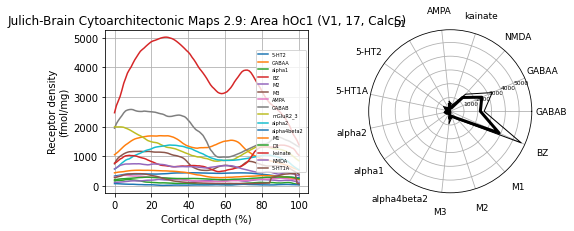

In [9]:
atlas.select_region("V1")
features = atlas.get_features(
    sb.modalities.ReceptorDistribution)
for r in features:
    fig = r.plot(r.region)

# Retrieving a connectivity matrix
For brainscapes, a connectivity matrix is a data feature like the others below, and can be found using the same `get_features` function just by choosing another modality. Siibra knows from the modality type that this type of data does not match to the selected brain region in the atlas, but to the selected parcellation. Therefore, `get_features` return connectivity datasets that are defined for the selected parcellation. 



In [10]:
matrices = atlas.get_features(
    sb.modalities.ConnectivityMatrix)

In [11]:
# we just take the first of possibly multiple delivered matrices
matrix = matrices[0]

To learn about the nature of the provided connectivity, the `src_info` attribute provides a detailed description of the dataset. 

In [12]:
print(matrix.src_name, '\n\n', matrix.src_info)

Average streamline counts from diffusion imaging, 1000BRAINS cohort 

 The human brain shows considerable interindividual variability, particularly during the course of aging, which is influenced by genetic and environmental factors. To characterize this variability across a wide range of subjects in the general population, large cohort data including brain imaging as well as a variety of phenotypic data are required. The 1000BRAINS study, which is based on the population-based Heinz Nixdorf Recall Study of the University of Duisburg-Essen (Germany), aims at studying this variability of brain structure, function and connectivity as well as cognition particularly in the older population in relation to influences such as genetic factors, lifestyle, urban environment or health conditions.The current data set on whole brain connectivity matrices of the HBP Human Brain Atlas regions reflects the variability of structural connections (i.e. fiber tracts) in this 1000BRAINS population sample. 

# Building a TVB model from atlas data

To ensure we're extracting receptor data which match the regions as defined in the connectivity matrix, we'll iterate through the node names in the connectivity and request receptor distribution data for the region with that name.

For now we collapse cortical depth to achieve mean field scalar values, but we can in a second step, simulate one neural mass per cortical depth value, so that the data can be expressed in far more detailed simulated dynamics.


In [13]:
%%capture
import utils

and now we loop through regions,

In [14]:
mnispace = sb.spaces.MNI152_2009C_NONL_ASYM
region_profiles = {}
region_centroids = []
region_is_cortical = []

for roi in matrix.column_names:
    
    # get region information
    centroid, is_cortical = utils.region_select_props(atlas, roi)
    region_centroids.append(centroid)
    region_is_cortical.append(is_cortical)
    
    # get region receptor information
    profiles = {}
    for feature in atlas.get_features(sb.modalities.ReceptorDistribution):
        for receptor, depth_density in feature.profiles.items():
            profiles[receptor] = np.fromiter(depth_density.values(), dtype=np.float32).mean()
    region_profiles[roi] = profiles

skipping Frontal-to-Temporal-I (GapMap) - right hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping Frontal-to-Temporal-I (GapMap) - left hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping Ch 123 (Basal Forebrain) - right hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping Ch 123 (Basal Forebrain) - left hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping Ch 4 (Basal Forebrain) - right hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping Ch 4 (Basal Forebrain) - left hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping LB (Amygdala) - right hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping LB (Amygdala) - left hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping CM (Amygdala) - right hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping CM (Amygdala) - left hemisphere: 'Atlas' object has no attribute 'regionprops'
skipping SF (Amygdala) - right hemisphere

The above cell does not always succeed in the collab because of memory requirements perhaps, so we persist a few of the variables above,

In [15]:
import pickle
region_data = dict(profiles=region_profiles, centroids=region_centroids, is_cortical=region_is_cortical)
with open('region_data.pickle', 'wb') as fd:
    pickle.dump(region_data, fd)

## TVB Connectivity

In [16]:
from tvb.simulator.lab import *

In [17]:
conn = connectivity.Connectivity(
    weights=matrix.matrix,
    tract_lengths=np.zeros_like(matrix.matrix),  # may become available later
    region_labels=np.array(matrix.column_names),
    cortical=np.array(region_is_cortical),
    centres=np.array(region_centroids),
)
conn.configure()

## TVB simulation

We can construct a simulation with just a connectome and let TVB fill in the rest of the details with defaults,

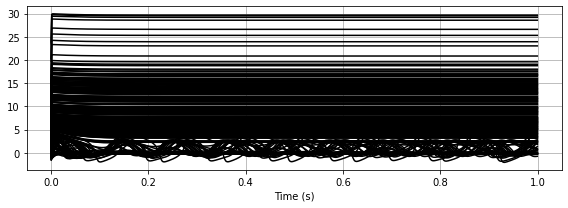

In [18]:
sim = simulator.Simulator(connectivity=conn).configure()
(t,y), = sim.run()

plt.figure(figsize=(8,3))
plt.plot(t*1e-3, y[:, 0, :, 0], 'k');
plt.xlabel('Time (s)')
plt.grid(1)
plt.tight_layout()

These are traces from the default alpha-band oscillator model, which usually should take on the range of -3 to 3, but here, many nodes are quite saturated positively, corresponding to an excitation block, while others are oscillating.

To avoid this disparity in region dynamics, we should normalize the connectivity:

In [19]:
norm_w = np.log(conn.weights.copy() + 1e-3)
np.fill_diagonal(norm_w, 0.0)
norm_w /= norm_w.max()
conn.weights[:] = norm_w
conn.configure()

Now we can run another simulation,

In [20]:
sim = simulator.Simulator(connectivity=conn).configure()
(t,y), = sim.run()

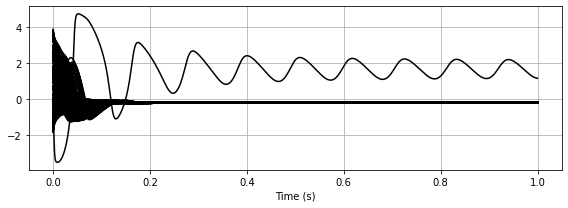

In [21]:
plt.figure(figsize=(8,3))
plt.plot(t*1e-3, y[:, 0, :, 0], 'k');
plt.xlabel('Time (s)')
plt.grid(1)
plt.tight_layout()

where we can see all nodes settle to a fixed point except one.

## Mapping receptor distributions to TVB parameters

Not all regions have the same receptors, first identify a consistent subset:

In [22]:
region_receptors = [set(v.keys()) for k, v in region_profiles.items() if v]
rri = region_receptors[0]
for rr in region_receptors[1:]:
    rri = rri.intersection(rr)
rri

{'5-HT1A',
 '5-HT2',
 'AMPA',
 'BZ',
 'D1',
 'GABAA',
 'GABAB',
 'M1',
 'M2',
 'NMDA',
 'alpha1',
 'alpha2',
 'alpha4beta2'}

The mapping to parameters is likely complex, but a frequent simplifying assupmtion in the literature is that network dynamics are sensitive to excitation-inhibition balance.  As a start, we will just look at the ratio of AMPA to GABAA, to focus on fast time scale excitation and inhibition,

In [23]:
region_params = []
param_keys = 'AMPA GABAA'.split()
for roi in matrix.column_names:
    profs = region_profiles[roi]
    if profs:
        region_params.append([profs[key] for key in param_keys])
    else:
        region_params.append([np.nan]*len(param_keys))
region_params = np.array(region_params)

For each receptor, fill in missing data with mean of known data,

In [24]:
for i, key in enumerate(param_keys):
    missing = ~np.isfinite(region_params[:, i])
    region_params[missing, i] = np.mean(region_params[~missing, i])

Finally, form an excitation-inhibition ratio, 

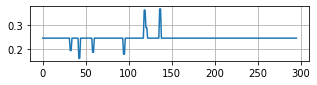

In [25]:
region_eir = region_params[:, 0] / region_params[:, 1]
plt.figure(figsize=(5,1))
plt.plot(region_eir)
plt.grid(1)

and use this as a parameter in TVB model for simulation:

In [26]:
model = models.Generic2dOscillator(a=region_eir+1)
sim = simulator.Simulator(model=model, connectivity=conn).configure()
(t,y), = sim.run()

In [27]:
t.shape, y.shape

((1024,), (1024, 1, 296, 1))

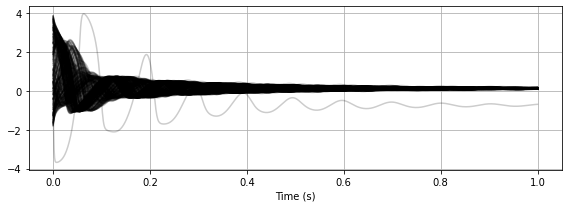

In [28]:
plt.figure(figsize=(8,3))
plt.plot(t*1e-3, y[:, 0, :, 0], 'k', alpha=0.2);
plt.xlabel('Time (s)')
plt.grid(1)
plt.tight_layout()

This is a typical transient at the start of a simulation, but now the transient reflects the regional variability of both the connectome and receptor distributions. To verify that, let's run again with uniform parametrization at the mean median value.

In [29]:
model = models.Generic2dOscillator(a=np.r_[np.median(region_eir) + 1])
sim = simulator.Simulator(model=model, connectivity=conn).configure()
(t,y2), = sim.run()

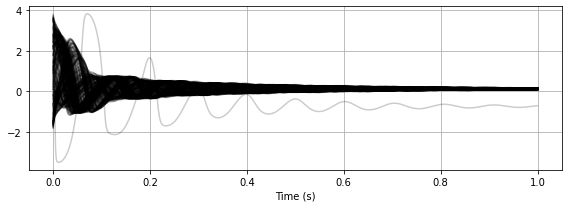

In [30]:
plt.figure(figsize=(8,3))
plt.plot(t*1e-3, y2[:, 0, :, 0], 'k', alpha=0.2);
plt.xlabel('Time (s)')
plt.grid(1)
plt.tight_layout()

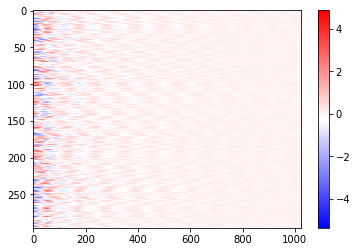

In [31]:
plt.imshow(y2[:, 0, :, 0].T - y[:, 0, :, 0].T, aspect='auto', cmap='bwr')
plt.colorbar()